In [258]:
# data science imports
import pandas as pd
import matplotlib.pyplot as plt

# census data imports
import censusdis.data as ced
import censusdis.maps as cem
from censusdis import states
from censusdis import datasets

# other imports
import os

In [259]:
# Load the API key
with open("../census_api_key.txt", "r") as f:
    CENSUS_API_KEY = f.read().strip()

# print(CENSUS_API_KEY)

In [261]:
# max cell size
pd.set_option("display.max_colwidth", 100)
# max length
pd.set_option("display.max_rows", 176)

In [262]:
dir(datasets)

['ABS_CB',
 'ABS_CBO',
 'ABS_CS',
 'ABS_MCB',
 'ABS_NESD',
 'ABS_NESDO',
 'ABS_TCB',
 'ACS1',
 'ACS1_CD113',
 'ACS1_CD115',
 'ACS1_CPROFILE',
 'ACS1_PROFILE',
 'ACS1_PUMS',
 'ACS1_PUMSPR',
 'ACS1_SDATAPROFILE_CD119',
 'ACS1_SPP',
 'ACS1_SUBJECT',
 'ACS3',
 'ACS3_CPROFILE',
 'ACS3_PROFILE',
 'ACS3_SPP',
 'ACS3_SUBJECT',
 'ACS5',
 'ACS5_AIAN',
 'ACS5_AIANPROFILE',
 'ACS5_CPROFILE',
 'ACS5_EEO',
 'ACS5_PROFILE',
 'ACS5_PUMS',
 'ACS5_PUMSPR',
 'ACS5_SPT',
 'ACS5_SPTPROFILE',
 'ACS5_SUBJECT',
 'ACSSE',
 'ACS_FLOWS',
 'ALL_LODES_DATA_SETS',
 'ASE_CSA',
 'ASE_CSCB',
 'ASE_CSCBO',
 'CBP',
 'CFSAREA',
 'CFSEXPORT',
 'CFSHAZMAT',
 'CFSPRELIM',
 'CFSPUMDEST',
 'CFSPUMORIG',
 'CFSTEMP',
 'CPS_ARTS_FEB',
 'CPS_ASEC_MAR',
 'CPS_BASIC_APR',
 'CPS_BASIC_AUG',
 'CPS_BASIC_DEC',
 'CPS_BASIC_FEB',
 'CPS_BASIC_JAN',
 'CPS_BASIC_JUL',
 'CPS_BASIC_JUN',
 'CPS_BASIC_MAR',
 'CPS_BASIC_MAY',
 'CPS_BASIC_NOV',
 'CPS_BASIC_OCT',
 'CPS_BASIC_SEP',
 'CPS_CIVIC_NOV',
 'CPS_CONTWORKER_FEB',
 'CPS_CONTWORKER_MAY',
 '

In [263]:
(
    ced.variables.all_data_sets()
    .loc[
        lambda x: x["DATASET"].str.contains("cps", case=False)
    ]
    ["DATASET"]
    .unique()
)

array(['cps/basic/apr', 'cps/basic/aug', 'cps/basic/dec', 'cps/basic/feb',
       'cps/basic/jan', 'cps/basic/jul', 'cps/basic/jun', 'cps/basic/mar',
       'cps/basic/may', 'cps/basic/nov', 'cps/basic/oct', 'cps/basic/sep',
       'cps/asec/mar', 'cps/internet/nov', 'cps/school/oct',
       'cps/voting/nov', 'cps/contworker/feb', 'cps/foodsec/apr',
       'cps/marital/jun', 'cps/race/may', 'cps/vets/aug', 'cps/dwjt/feb',
       'cps/internet/oct', 'cps/vets/sep', 'cps/worksched/may',
       'cps/fertility/jun', 'cps/foodsec/aug', 'cps/internet/dec',
       'cps/foodsec/sep', 'cps/internet/aug', 'cps/foodsec/dec',
       'cps/internet/sep', 'cps/dwjt/jan', 'cps/library/oct',
       'cps/pubarts/aug', 'cps/volunteer/sep', 'cps/tobacco/aug',
       'cps/tobacco/may', 'cps/tobacco/jan', 'cps/civic/nov',
       'cps/immigration/aug', 'cps/unbank/jan', 'cps/vets/jul',
       'cps/internet/jul', 'cps/unbank/jun', 'cps/disability/may',
       'cps/pubarts/jul', 'cps/arts/feb', 'cps/tobacco/ju

In [123]:
DATASET = "cps/basic/jan"
YEAR = 2025

groups = ced.variables.all_groups(DATASET, YEAR)
groups.head()

,DATASET,YEAR,GROUP,DESCRIPTION


In [274]:
cps_vars = ced.variables.all_variables(DATASET, YEAR, None)
cps_vars.head()

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
0,2025,cps/basic/jan,N/A,CBSA,Metropolitan Core Based Statistical Area FIPS Code,NaN,"{'34740': 'Muskegon, MI', '34980': 'Nashville-Davidson--Murfreesboro--Franklin, TN', '39740': 'R..."
1,2025,cps/basic/jan,N/A,COUNTY,FIPS County Code,NaN,{'000': 'Not Identified'}
2,2025,cps/basic/jan,N/A,CSA,Combined Statistical Area FIPS Code,NaN,"{'216': 'Denver-Aurora, CO', '438': 'Portland-Lewiston-South Portland, ME', '482': 'Salt Lake Ci..."
3,2025,cps/basic/jan,N/A,DIVISION,DIVISION,NaN,"{'2': 'MIDDLE ATLANTIC', '8': 'MOUNTAIN', '5': 'SOUTH ATLANTIC', '7': 'WEST NORTH CENTRAL', '9':..."
4,2025,cps/basic/jan,N/A,GTCBSAST,Principal City/Balance Status,PWSSWGT,"{'3': 'Nonmetroploitan', '2': 'Balance Metropolitan', '1': 'Principal City', '4': 'Not Identified'}"


In [ ]:
# look for the in/not in variable (PRCIVLF)
cps_vars[ cps_vars["LABEL"].str.contains("part of", case = False)]

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
141,2025,cps/basic/jan,N/A,PRCIVLF,Labor Force-part of/not part of,PWCMPWGT,"{'-1': 'In Universe, Met No Conditions To Assign', '2': 'Not In Civilian Labor Force', '1': 'In ..."


In [273]:
# check the categories
cps_vars[ cps_vars["LABEL"].str.contains("part of", case = False)].iloc[0].VALUES


{'-1': 'In Universe, Met No Conditions To Assign',
 '2': 'Not In Civilian Labor Force',
 '1': 'In Civilian Labor Force'}

In [309]:
# set your download variables
variables = {
    "PRCIVLF": "labor_force",
    # the recommended weight from the variables table
    "PWCMPWGT": "employment_weight",
}

jan_cps = (
    ced.download(
        DATASET,
        YEAR,
        download_variables = variables.keys(),
        state = "*",
    )
    # rename the columns
    .rename( columns = variables )
)

jan_cps["STATE"] = jan_cps["STATE"].str.zfill(2)

jan_cps.head()



,STATE,labor_force,employment_weight
0,05,1,1598.1743
1,05,1,1686.0648
2,02,1,485.6935
3,02,2,500.7823
4,01,2,1587.5833


In [312]:
jan_cps["state_name"] = jan_cps["STATE"].map(states.ABBREVIATIONS_FROM_IDS)
jan_cps

,STATE,labor_force,employment_weight,state_name
0,05,1,1598.1743,AR
1,05,1,1686.0648,AR
2,02,1,485.6935,AK
3,02,2,500.7823,AK
4,01,2,1587.5833,AL
...,...,...,...,...
97721,39,1,5987.3232,OH
97722,39,-1,0.0000,OH
97723,39,-1,0.0000,OH
97724,39,-1,0.0000,OH


In [316]:
in_force = (
    jan_cps[ jan_cps["labor_force"] == 1 ]
    .groupby("STATE")
    .agg(
        in_force = ("employment_weight", "sum")
    )
)

in_force.head()

,in_force
STATE,
01,2.341148e+06
02,3.672055e+05
04,3.858597e+06
05,1.404432e+06
06,1.975506e+07


In [318]:
labor_universe = (
    jan_cps
    .groupby("STATE")
    .agg(
        total = ("employment_weight", "sum")
    )
)

labor_universe.head()

,total
STATE,
01,4.100492e+06
02,5.583230e+05
04,6.141483e+06
05,2.432194e+06
06,3.173265e+07


In [350]:
with_percent = pd.merge(
    in_force,
    labor_universe,
    on = "STATE"
).assign(
    percent_inforce = lambda x: x["in_force"]/x["total"] * 100
)

with_percent.head()

,in_force,total,percent_inforce
STATE,,,
01,2.341148e+06,4.100492e+06,57.094308
02,3.672055e+05,5.583230e+05,65.769359
04,3.858597e+06,6.141483e+06,62.828418
05,1.404432e+06,2.432194e+06,57.743422
06,1.975506e+07,3.173265e+07,62.254677


In [351]:
# get geo
state_geo = (
    ced
    .download(
        "acs/acs1", 
        2023, 
        download_variables=["NAME"], 
        state="*",
        with_geometry = True
    )
)  

state_geo.head()

,STATE,NAME,geometry
0,01,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 30.50886, -88.04565 30.51331, -88.04197 30.51738, ..."
1,02,Alaska,"MULTIPOLYGON (((-131.61758 54.94795, -131.61073 54.95101, -131.60693 54.95439, -131.60084 54.955..."
2,04,Arizona,"POLYGON ((-114.81629 32.50804, -114.81432 32.50902, -114.81183 32.50864, -114.81016 32.50838, -1..."
3,05,Arkansas,"POLYGON ((-94.61792 36.49941, -94.61765 36.49941, -94.55929 36.4995, -94.55465 36.49946, -94.519..."
4,06,California,"MULTIPOLYGON (((-118.60442 33.47855, -118.59878 33.47794, -118.58594 33.47382, -118.58026 33.475..."


In [352]:
with_geo = (
    state_geo
    .merge(
        with_percent,
        on = "STATE"
    )
)

with_geo.head()

,STATE,NAME,geometry,in_force,total,percent_inforce
0,01,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 30.50886, -88.04565 30.51331, -88.04197 30.51738, ...",2.341148e+06,4.100492e+06,57.094308
1,02,Alaska,"MULTIPOLYGON (((-131.61758 54.94795, -131.61073 54.95101, -131.60693 54.95439, -131.60084 54.955...",3.672055e+05,5.583230e+05,65.769359
2,04,Arizona,"POLYGON ((-114.81629 32.50804, -114.81432 32.50902, -114.81183 32.50864, -114.81016 32.50838, -1...",3.858597e+06,6.141483e+06,62.828418
3,05,Arkansas,"POLYGON ((-94.61792 36.49941, -94.61765 36.49941, -94.55929 36.4995, -94.55465 36.49946, -94.519...",1.404432e+06,2.432194e+06,57.743422
4,06,California,"MULTIPOLYGON (((-118.60442 33.47855, -118.59878 33.47794, -118.58594 33.47382, -118.58026 33.475...",1.975506e+07,3.173265e+07,62.254677


Text(0.5, 1.0, 'Percent eligible adults in the civilian labor force')

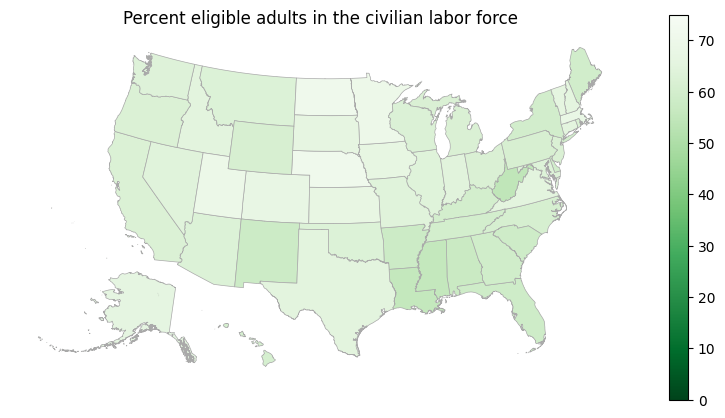

In [399]:
ax = cem.plot_us(
    with_geo,
    column = "percent_inforce",
    cmap = "Greens_r",
    legend = True,
    vmin = 0,
    vmax = 75,
    figsize = (10, 5),
    edgecolor = "darkgray",
    linewidth = 0.5
)

ax.axis("off")
ax.set_title("Percent eligible adults in the civilian labor force")

---
---
---